[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


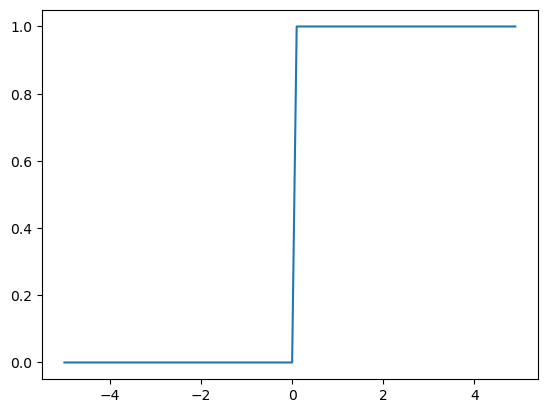

In [4]:
import numpy as np
import matplotlib.pylab as plt


def step_function(x):
    return np.array(x > 0)


x = np.arange(-5.0, 5.0, 0.1)
y = step_function(x)
plt.plot(x, y)

In [22]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid(x)
plt.plot(x, y)

NameError: name 'plt' is not defined

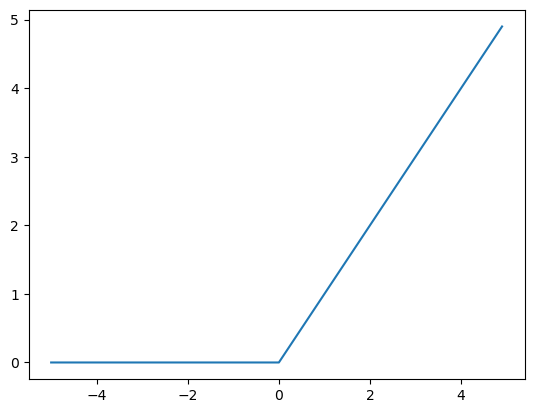

In [6]:
def relu(x):
    return np.maximum(0, x)


x = np.arange(-5.0, 5.0, 0.1)
y = relu(x)
plt.plot(x, y)

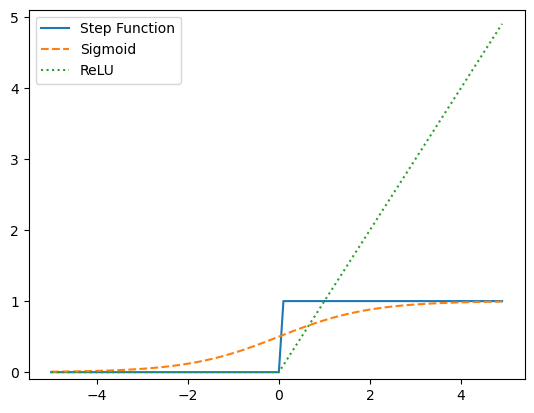

In [11]:
x = np.arange(-5.0, 5.0, 0.1)
y_step = step_function(x)
y_sigmoid = sigmoid(x)
y_relu = relu(x)
plt.plot(x, y_step, label="Step Function")
plt.plot(x, y_sigmoid, label="Sigmoid", linestyle="--")
plt.plot(x, y_relu, linestyle=":", label="ReLU")
plt.ylim(-0.1, 5.1)
plt.legend()
plt.show()

In [7]:
import numpy as np

from common.functions import cross_entropy_error, softmax


class SimpleNet:
    def __init__(self) -> None:
        self.W = np.random.randn(2, 3)

    def predict(self, x: np.ndarray) -> np.ndarray:
        return np.dot(x, self.W)

    def loss(self, x: np.ndarray, t: np.ndarray) -> float:
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss


net = SimpleNet()
print("net.W:", net.W)

x = np.array([0.6, 0.9])
t = np.array([1, 0, 0])
print(net.loss(x, t))

net.W: [[-1.14619136  0.43448014 -0.48490268]
 [-1.48234685  0.61206031 -0.15120816]]
3.132443192824007


In [9]:
def numerical_gradient(f: callable, x: np.ndarray) -> np.ndarray:
    """勾配の算出

    Args:
        f (function): 損失関数
        x (numpy.ndarray): 勾配を調べたい重みパラメーターの配列

    Returns:
        numpy.ndarray: 勾配
    """
    h = 1e-4
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=["multi_index"])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f()
        x[idx] = tmp_val - h
        fxh2 = f()
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val
        it.iternext()
    return grad


def f(x: float):
    return net.loss(x, t)


numerical_gradient(f, x)

(0,)
(1,)


In [24]:
from common.functions import sigmoid_grad


class TwoLayerNet:
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        weight_init_std: int = 0.01,
    ):
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b2"] = np.zeros(output_size)

    def predict(self, x: np.ndarray):
        W1, W2 = self.params["W1"], self.params["W2"]
        b1, b2 = self.params["b1"], self.params["b2"]
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        return y

    def loss(self, x: np.ndarray, t: np.ndarray):
        y = self.predict(x)
        return cross_entropy_error(y, t)

    def accuracy(self, x: np.ndarray, t: np.ndarray):
        y = self.predict(x)
        max_y = np.argmax(y, axis=1)
        max_t = np.argmax(t, axis=1)
        accuracy = np.sum(max_y == max_t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x: np.ndarray, t: np.ndarray):
        # 本文では引数はダミーだったので今回の実装では省く。
        loss_W = lambda: self.loss(x, t)

        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        return grads

    def gradient(self, x: np.ndarray, t: np.ndarray):
        W1, W2 = self.params["W1"], self.params["W2"]
        b1, b2 = self.params["b1"], self.params["b2"]
        grads = {}

        batch_num = x.shape[0]

        # フォワードの処理
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # バックワードの処理
        """
        dy は予測値 y と教師ラベル t の誤差です。バッチサイズで割ることで平均化します。
        """
        dy = (y - t) / batch_num
        grads["W2"] = np.dot(z1.T, dy)
        grads["b2"] = np.dot(dy, axis=0)

        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads["W1"] = np.dot(x.T, da1)
        grads["b1"] = np.sum(da1, axis=0)
        return grads


net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
x = np.random.rand(100, 784)
y = net.predict(x)
print(y)

[[0.09240367 0.10106059 0.10606127 0.09594204 0.09816229 0.09708076
  0.10976868 0.10546835 0.09144562 0.10260673]
 [0.09250952 0.10143484 0.10599169 0.09570451 0.09819054 0.09714292
  0.10982933 0.10567165 0.09127142 0.10225358]
 [0.09261602 0.1015853  0.10557706 0.09579455 0.09819508 0.09735187
  0.10983024 0.10602531 0.09115176 0.10187281]
 [0.09206122 0.10121802 0.10604648 0.0958299  0.09849466 0.0971654
  0.10966988 0.10547841 0.09141521 0.10262083]
 [0.09221864 0.10131176 0.10590052 0.09559433 0.09813711 0.09700098
  0.11012937 0.10567823 0.09121933 0.10280973]
 [0.09253337 0.10141375 0.105963   0.09541637 0.09868139 0.09711023
  0.10982152 0.10572756 0.09113333 0.10219947]
 [0.09252979 0.10119312 0.10554327 0.09566876 0.09853862 0.09704922
  0.10977788 0.10612534 0.09144353 0.10213046]
 [0.09258572 0.10103397 0.10589843 0.09555374 0.09853015 0.09715235
  0.10965803 0.10554871 0.09160619 0.1024327 ]
 [0.0921731  0.10141161 0.10571892 0.09554371 0.09877955 0.09710288
  0.1098675  

In [19]:
array = np.array([10, 12, 13, 14])
t = np.array([1, 2, 3, 4])
(array - t) / 2

array([4.5, 5. , 5. , 5. ])